# Import the Normalized Database

In [1]:
import numpy as np 
db = np.load('db_5SS_norm_s7408.npz')
print(db['cplrData'].shape)
print(db['mechData'].shape)
cplr=db['cplrData']
mech=db['mechData']

(7408, 100, 3)
(7408, 11, 3)


In [2]:
#%matplotlib inline
%matplotlib notebook

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from numpy import linalg as LA


def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))

<IPython.core.display.Javascript object>


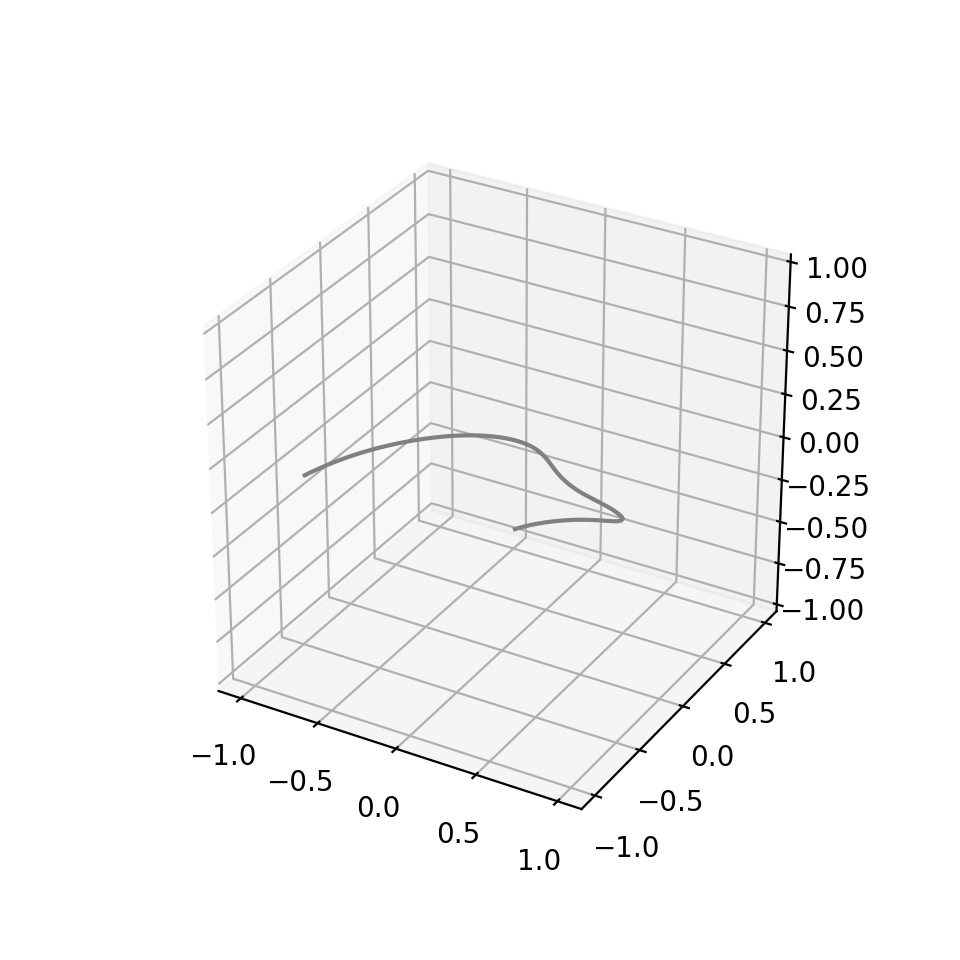

In [3]:
Pts=cplr[21]
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(Pts, ax, 1)

# Remove similar paths to enhance variety

In its present state, the database has more samples of coupler paths which are more probable while lesser samples of other more diverse. However, we would like our NN to handle all types of coupler paths with same efficiency and accuracy. To overcome this bias, we select a limited number of diverse paths from the complete database. Thus, this new balanced dataset contains equal samples of unique and diverse paths.

## P2 Norm (two equally split curves)

We use P2 norm of difference between two curves as the metric to compare the similarity between two curves. This metric cannot detect same curves which have undergone transformation like translation, rotation or scaling. However, since we have already done that in the preprocessing, it works as a good metric. To check for parametrization in inverse direction, we also check the flipped paths to compare P2 norm. Unfortunately, partial matching is not possible with this metric.

In [230]:
def compareEqualCurve(path1, path2):
    delta1=LA.norm(path1-path2)/len(path1)
    delta2=LA.norm(path1-np.fliplr(path2))/len(path1) #for inverse time parametrization
    return np.array([delta1,delta2]).min()

def findDiverseP2norm(pathdb, threshold):
    DiverseCplr=np.array([pathdb[0]])
    for i in range(1,len(pathdb)):
        if i%500==0:
            print("Paths Processed:"+ str(i)+" ,unique Paths in DB:"+str(DiverseCplr.shape[0]))
        
        path1=pathdb[i]
        diff=np.array([])
        for path2 in DiverseCplr:
            diff=np.append(diff,[compareEqualCurve(path1, path2)])
        
        if diff.min()>threshold:
            DiverseCplr=np.append(DiverseCplr,[path1], axis=0)
    
    print("Database size before removing similar paths: " + str(cplr.shape[0]))
    print("Database size after removing similar paths: " + str(DiverseCplr.shape[0]))
    return DiverseCplr

In [231]:
DiverseCplr=findDiverseP2norm(cplr, .06)

Paths Processed:500 ,unique Paths in DB:9
Paths Processed:1000 ,unique Paths in DB:10
Paths Processed:1500 ,unique Paths in DB:11
Paths Processed:2000 ,unique Paths in DB:14
Paths Processed:2500 ,unique Paths in DB:17
Paths Processed:3000 ,unique Paths in DB:20
Paths Processed:3500 ,unique Paths in DB:21
Paths Processed:4000 ,unique Paths in DB:22
Paths Processed:4500 ,unique Paths in DB:23
Paths Processed:5000 ,unique Paths in DB:25
Paths Processed:5500 ,unique Paths in DB:26
Paths Processed:6000 ,unique Paths in DB:26
Paths Processed:6500 ,unique Paths in DB:26
Paths Processed:7000 ,unique Paths in DB:26
Database size before removing similar paths: 7408
Database size after removing similar paths: 26


<IPython.core.display.Javascript object>


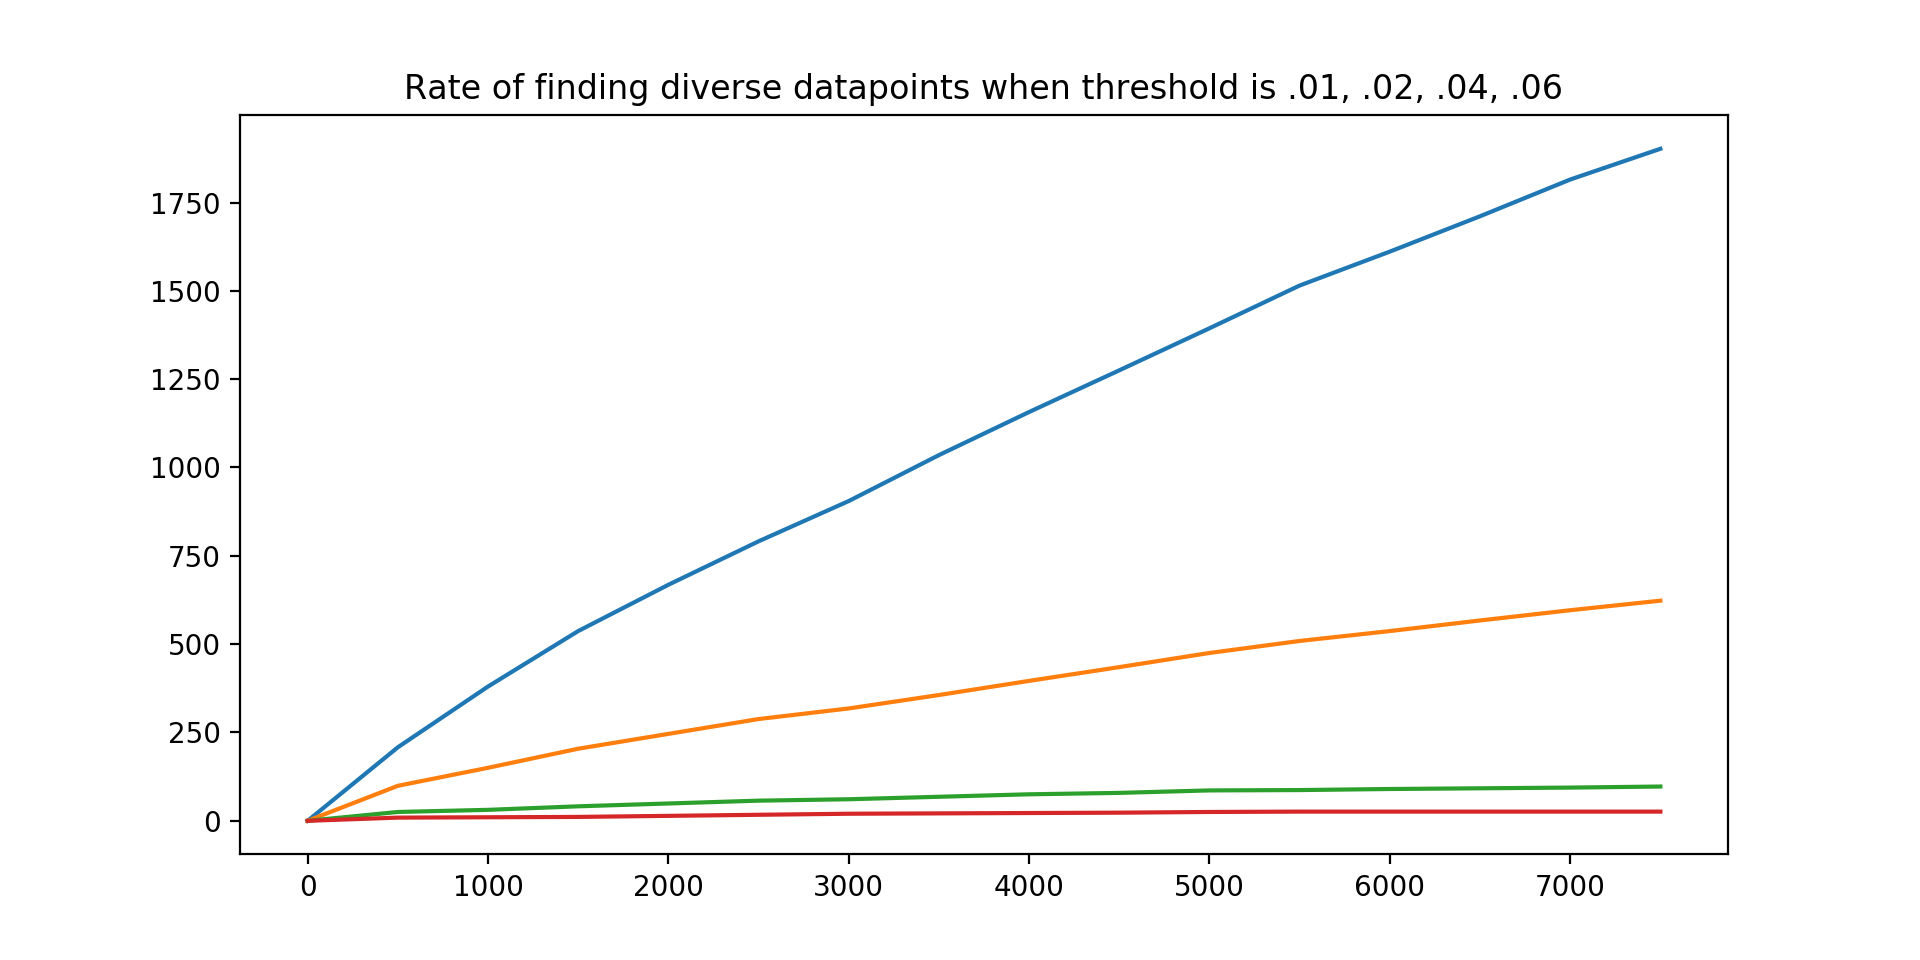

Text(0.5, 1.0, 'Rate of finding diverse datapoints when threshold is .01, .02, .04, .06')

In [215]:
# Rate at which diverse data is added
# Ideally, to represent all of the curves, data should be added until the plot saturates
x=range(0,8000,500)
y_01=[0,208,380,537,668,791,905,1035,1157,1275,1394,1515,1611,1711,1815,1902]
y_02=[0,99,150,204,246,288,318,356,396,435,475,509,537,567,596,623]
y_04=[0,25,31,41,49,57,61,68,75,79,86,87,90,92,94,97]
y_06=[0,9,10,11,14,17,20,21,22,23,25,26,26,26,26,26]
fig = plt.figure(figsize=plt.figaspect(1/2))
ax = fig.add_subplot(111)
ax.plot(x,y_01)
ax.plot(x,y_02)
ax.plot(x,y_04)
ax.plot(x,y_06)
ax.set_title("Rate of finding diverse datapoints when threshold is .01, .02, .04, .06")

<IPython.core.display.Javascript object>


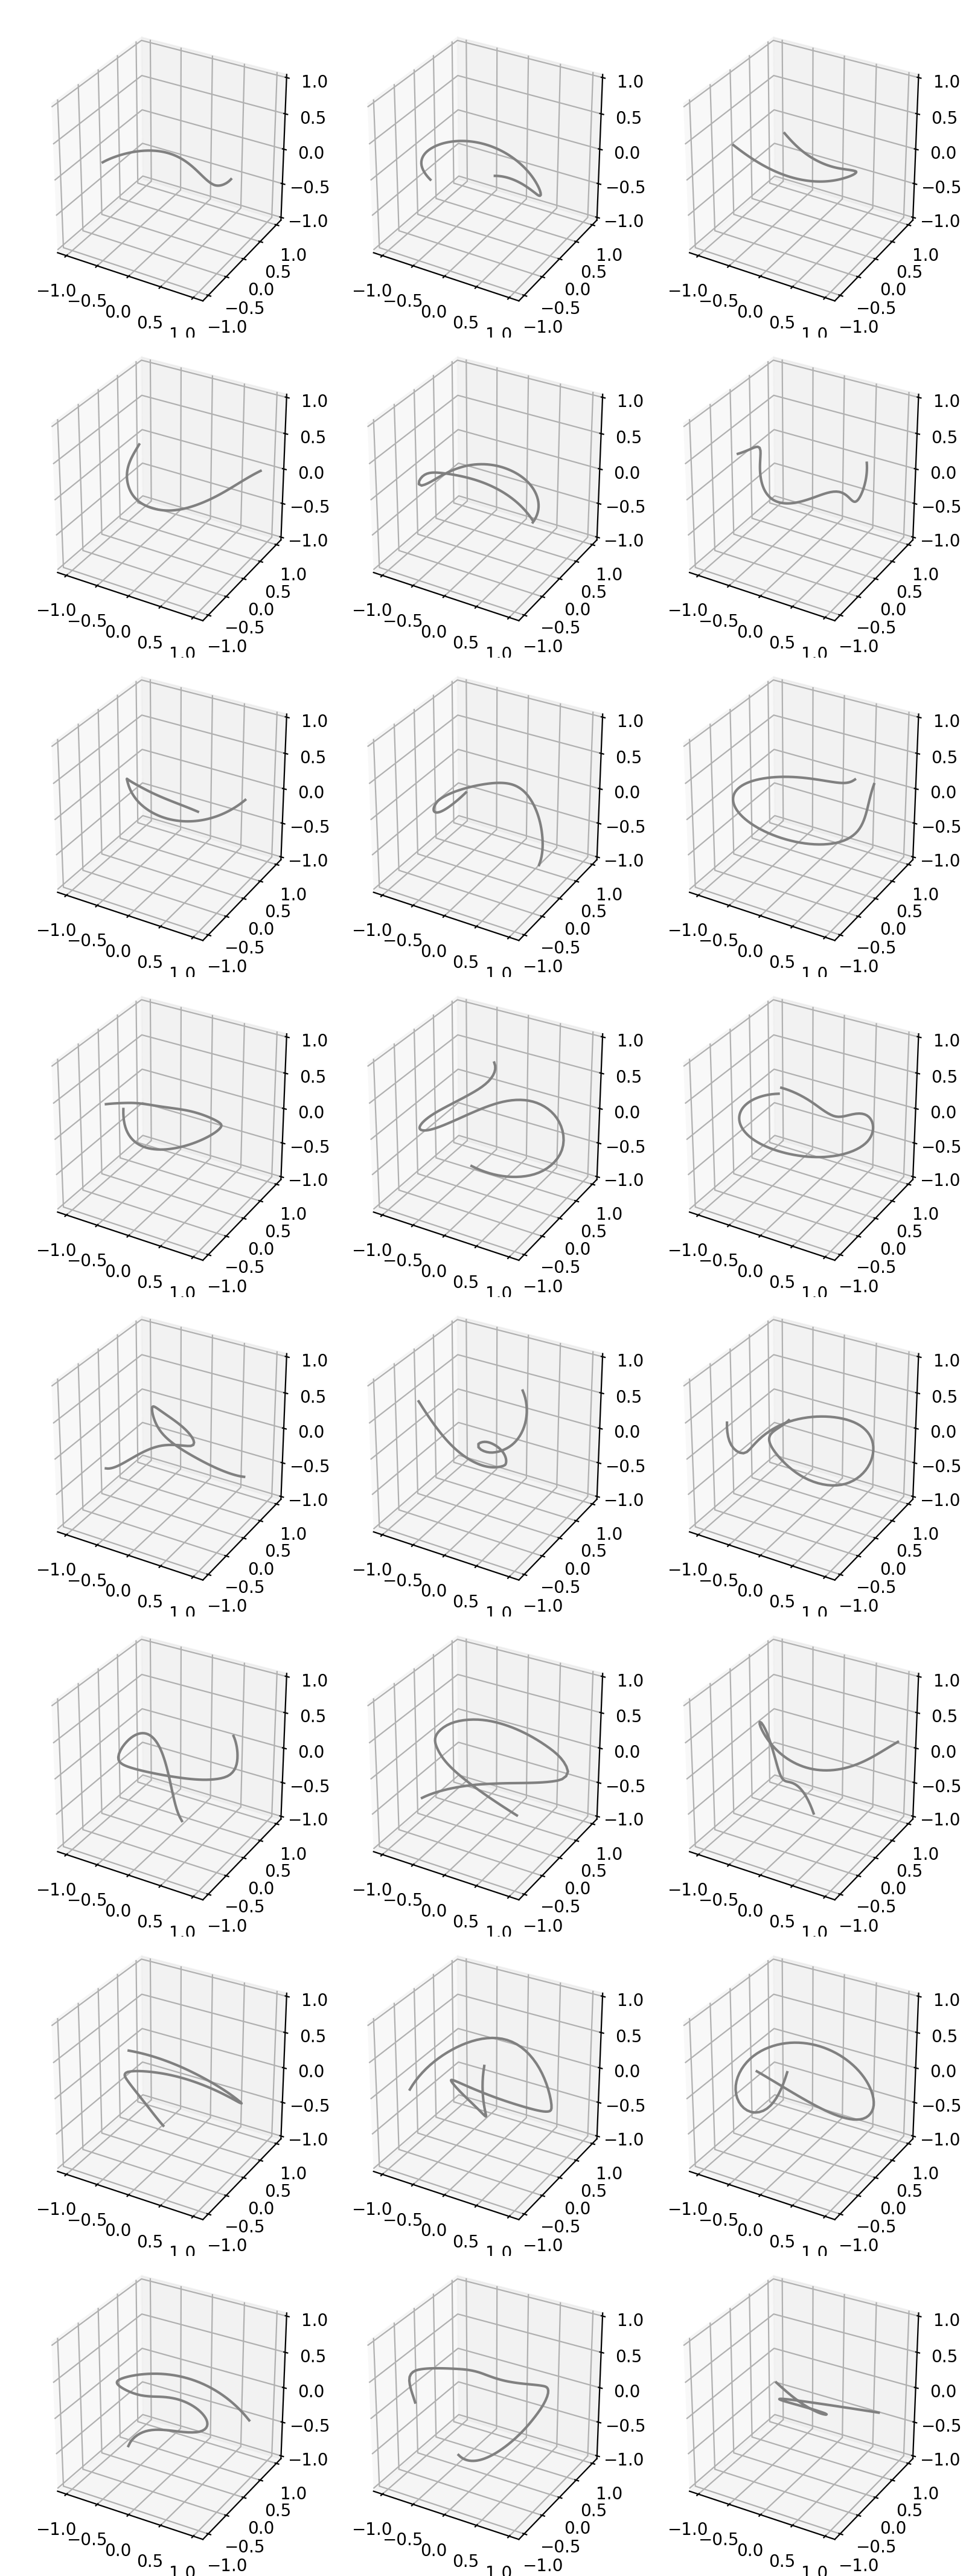

In [232]:
rows=8
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
for i in range(rows):
    for j in range(cols):
        Pts=DiverseCplr[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(rows, cols, path_index, projection='3d')
        plotPath(Pts, ax, 1)
        #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
plt.tight_layout()
plt.show()

## P2 Norm (two unequally split curves due to arc length param)

In [104]:
# Calculate the total arc length of a 3D curve
def calcArcLen(path):
    ArcLen=0
    for j in range(0,len(path)-1):
        d=LA.norm(path[j]-path[j+1])
        ArcLen+=d
    return ArcLen

# Calculate the discrete points according to arc-length parametrization
from scipy import interpolate
def normalizePathPts(Path, num_pts=100):
    xp=Path[:,0]
    yp=Path[:,1]
    zp=Path[:,2]
    
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]

    # Fit cubic B-spline to the data points
    tck, u =interpolate.splprep([xp,yp,zp],s=.01)
    u_fine = np.linspace(0,1,num_pts)
    x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
    Path_100 = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_100

def arcLenParam(path):
    S=calcArcLen(path)
    n=np.around(S*40)
    ArcParam=np.linspace(0, S, num=n)
    # Heusistic- For unit length, we calculate 40 discrete points.
    # (so that 2.5 unit curve(mean arc length of data) has 100 pts)
    ArcPath=normalizePathPts(path, n)
    return ArcPath, ArcParam

In [105]:
# Find Arc Length Parametrized paths i.e. t=[0,ArcL] 
# Distance between each discrete point should be equal.
ArcCplr=[]
ArcLenParam=[]
for i in range(len(cplr)):
    ArcPath, ArcParam= arcLenParam(cplr[i])
    ArcCplr.append(np.array(ArcPath))
    ArcLenParam.append(np.array(ArcParam))

<IPython.core.display.Javascript object>


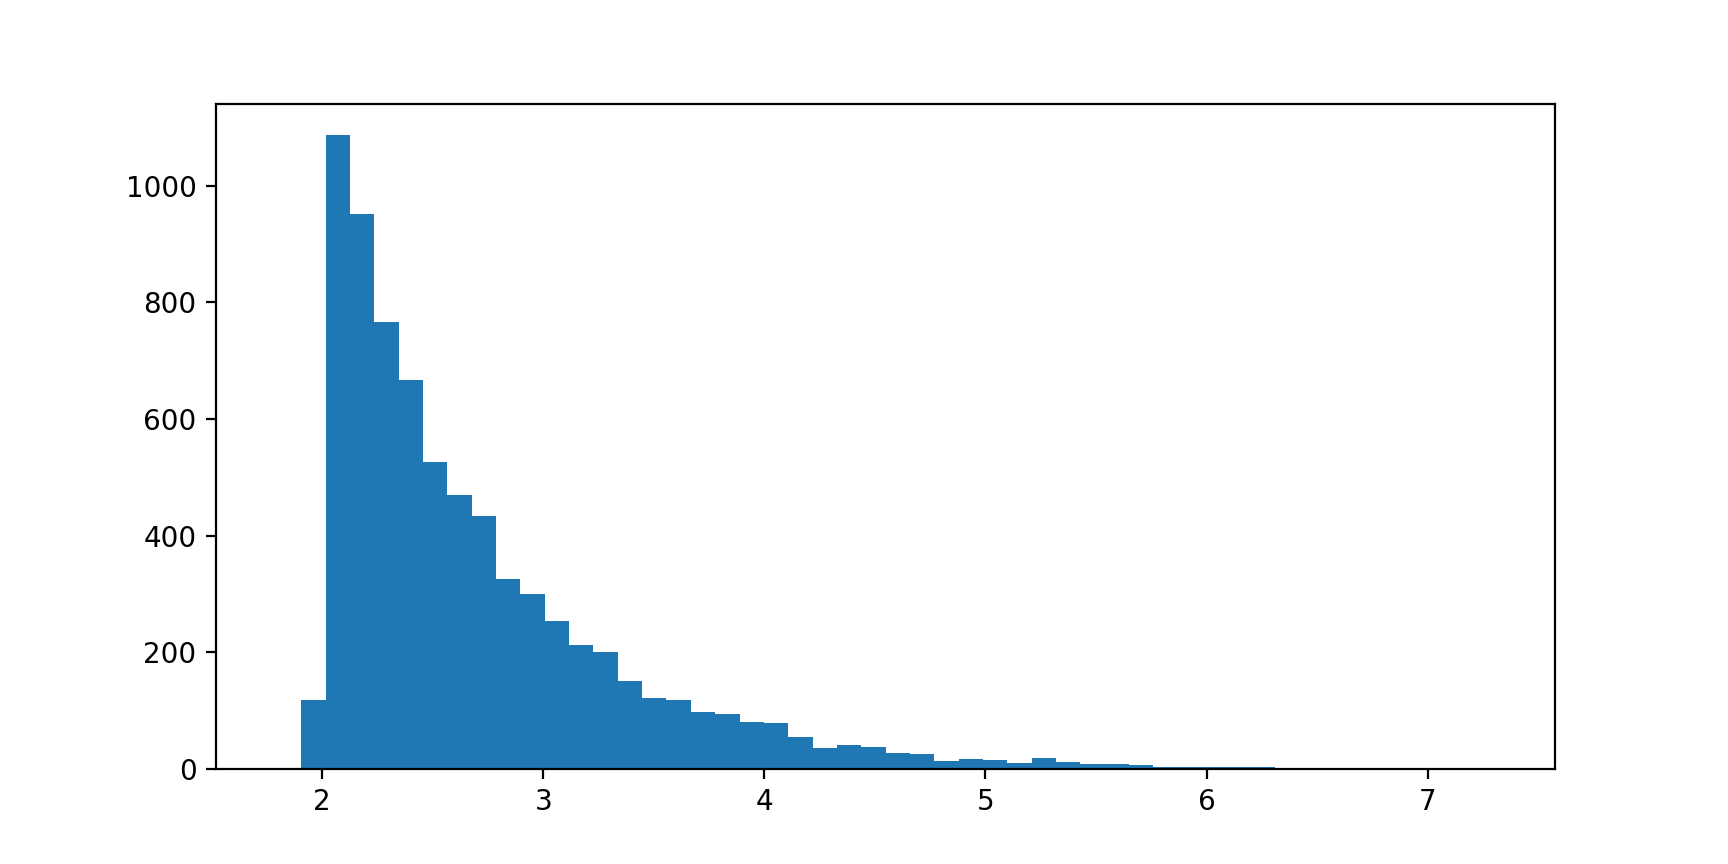

Max Arc Length: 7.301325763403286 , Index: 2743
Min Arc Length: 1.7952045854358076 , Index: 4555
Mean Arc Length: 2.696756906271792


In [106]:
# Arc length Analysis
ArcLens=[]
for i in range(cplr.shape[0]):
    ArcLen=ArcLenParam[i][-1]
    ArcLens.append(ArcLen)
    
# Plot histogram of ArcLengths
fig = plt.figure(figsize=.9*plt.figaspect(1/2))
ax = fig.add_subplot(1, 1, 1)
plt.hist(ArcLens,50)
plt.show()
print("Max Arc Length: "+ str(np.max(ArcLens)) +" , Index: " +str(np.argmax(ArcLens)))
print("Min Arc Length: "+ str(np.min(ArcLens)) +" , Index: " +str(np.argmin(ArcLens)))
print("Mean Arc Length: "+ str(np.mean(ArcLens)))

In [235]:
def compareUnequalCurve(path1, path2):
    if len(path1)>len(path2):
        pathL=path1
        pathS=path2
    else:
        pathL=path2
        pathS=path1
    
    dl=len(pathL)-len(pathS)
    delta=np.array([])
    
    # Check at every 10 discrete point increments.
    for i in range(0,dl+1,10):
        l=len(pathS)
        delta=np.append(delta,compareEqualCurve(pathL[i:l+i], pathS))
    return delta.min()

def findDiverseP2norm_Arc(pathdb, threshold):
    DiverseCplr=[np.array(pathdb[0])]
    for i in range(1,len(pathdb)):
        if i%500==0:
            print("Paths Processed:"+ str(i)+" ,unique Paths in DB:"+str(len(DiverseCplr)))
        
        path1=pathdb[i]
        diff=np.array([])
        for path2 in DiverseCplr:
            diff=np.append(diff,[compareUnequalCurve(path1, path2)])
        
        #print(diff)
        if diff.min()>threshold:
            DiverseCplr.append(path1)
        else:
            similar_index=np.argmin(diff)
            divLen=len(DiverseCplr[similar_index])
            candLen=len(path1)
            if candLen>divLen:
                DiverseCplr[similar_index]=path1
    
    print("Database size before removing similar paths: " + str(len(pathdb)))
    print("Database size after removing similar paths: " + str(len(DiverseCplr)))
    return DiverseCplr

In [239]:
DiverseCplrArc=findDiverseP2norm_Arc(ArcCplr, .01)

Paths Processed:500 ,unique Paths in DB:229
Paths Processed:1000 ,unique Paths in DB:391
Paths Processed:1500 ,unique Paths in DB:539
Paths Processed:2000 ,unique Paths in DB:685
Paths Processed:2500 ,unique Paths in DB:809
Paths Processed:3000 ,unique Paths in DB:924
Paths Processed:3500 ,unique Paths in DB:1049
Paths Processed:4000 ,unique Paths in DB:1167
Paths Processed:4500 ,unique Paths in DB:1287
Paths Processed:5000 ,unique Paths in DB:1406
Paths Processed:5500 ,unique Paths in DB:1519
Paths Processed:6000 ,unique Paths in DB:1616
Paths Processed:6500 ,unique Paths in DB:1709
Paths Processed:7000 ,unique Paths in DB:1807
Database size before removing similar paths: 7408
Database size after removing similar paths: 1877


<IPython.core.display.Javascript object>


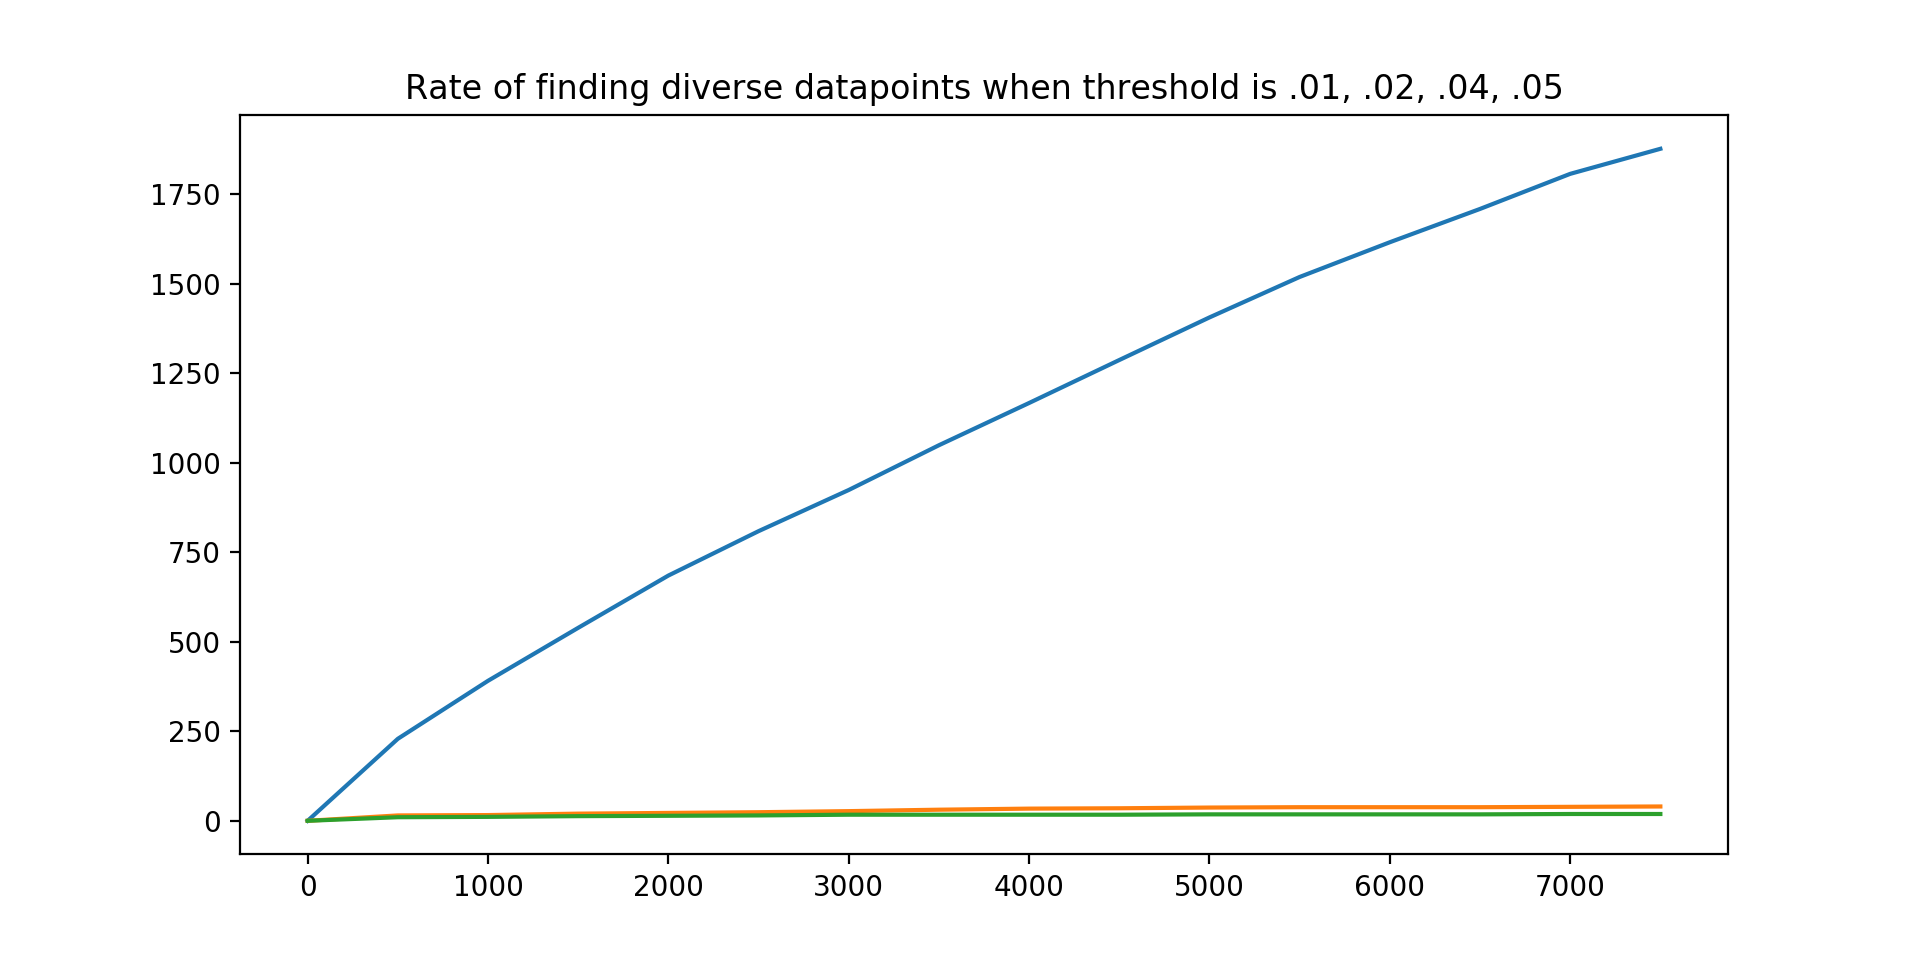

Text(0.5, 1.0, 'Rate of finding diverse datapoints when threshold is .01, .02, .04, .05')

In [241]:
# Rate at which diverse data is added
# Ideally, to represent all of the curves, data should be added until the plot saturates
x=range(0,8000,500)
y_01=[0,229,391,539,685,809,924,1049,1167,1287,1406,1519,1616,1709,1807,1877]
#y_02=[0,99,150,204,246,288,318,356,396,435,475,509,537,567,596,623]
y_04=[0,15,16,20,22,24,27,31,34,35,37,38,38,38,39,40]
y_05=[0,10,11,13,14,15,17,17,17,17,18,18,18,18,19,19]
fig = plt.figure(figsize=plt.figaspect(1/2))
ax = fig.add_subplot(111)
ax.plot(x,y_01)
#ax.plot(x,y_02)
ax.plot(x,y_04)
ax.plot(x,y_05)
ax.set_title("Rate of finding diverse datapoints when threshold is .01, .02, .04, .05")

<IPython.core.display.Javascript object>


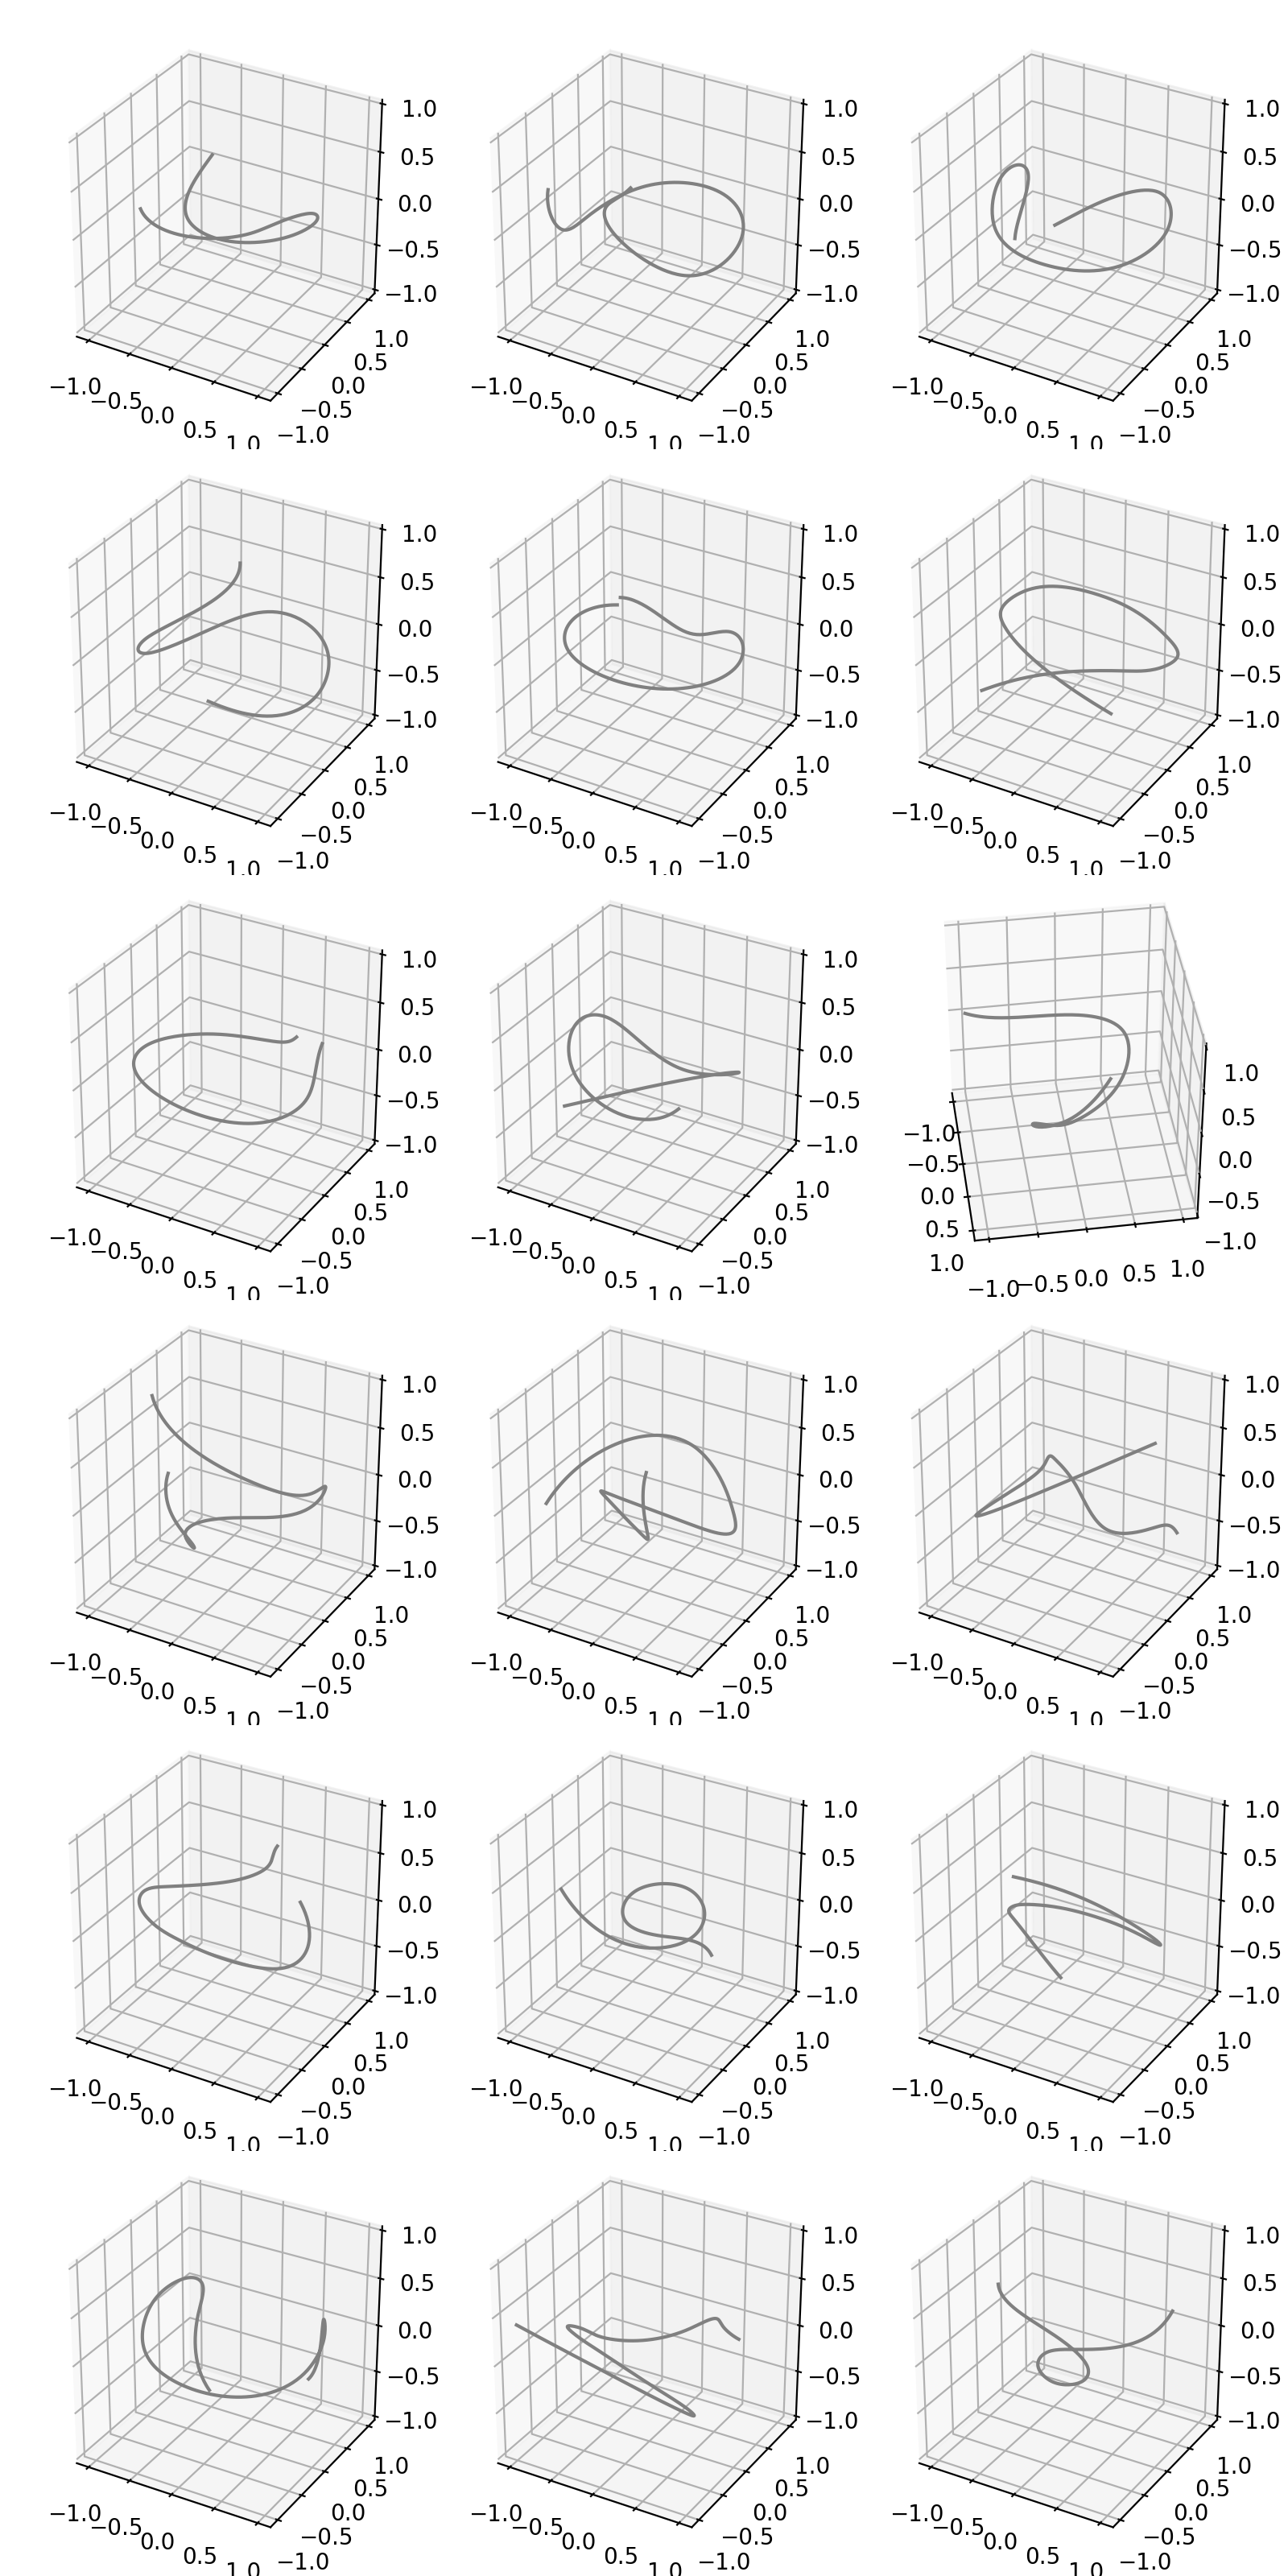

In [207]:
rows=6
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
for i in range(rows):
    for j in range(cols):
        Pts=DiverseCplrArc[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(rows, cols, path_index, projection='3d')
        plotPath(Pts, ax, 1)
        #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
plt.tight_layout()
plt.show()

## Frenet frame descriptors (Curvature and Torsion)

According to the "fundamental theorem of space curves" in differential geometry, every regular curve in three-dimensional space, with non-zero curvature, has its shape (and size) completely determined by its curvature and torsion. Thus, a better metric to compare the similarity of two curves are these Frenet–Serret Descriptors. The curvature is always positive while the torsion can be negative.

These descriptors are invariant to spatial translation and rotation. However, they are not scaling invariant. If the curve is scaled uniformly $\alpha$ times, the curvature and torsion scales $\frac{1}{\alpha}$ times. Thus, matching at same scale is possible. Also, the Frenet–Serret descritors can be successfully used to compare two curves of unequal length and match them when one is a part of another. This approach is thus better than the P2 norm comparision.

Intrestingly, the intregral of curvature and torsion are scaling invariant in addition to translation and rotation and thus best used for curve comparision.

In [96]:
def normalizePathPts(Path, num_pts=100):
    xp=Path[:,0]
    yp=Path[:,1]
    zp=Path[:,2]
    
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]

    # Fit cubic B-spline to the data points
    tck, u =interpolate.splprep([xp,yp,zp],s=.01)
    u_fine = np.linspace(0,1,num_pts)
    x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
    Path_100 = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_100


# Find a b-spline curve with its first and second order diff
def calcCurveArcLenParam(path):
    
    

# Find Frenet Frame including curvature and Torision
def calcFrenetDesc(path, ArcLenParam):
    ds=ArcLenParam[1]-ArcLenParam[0]
    V=np.diff(path, axis=0)/ds
    AbsV=np.linalg.norm(V, axis=1)
    AbsV=np.vstack((AbsV,AbsV,AbsV)).T
    T=V/AbsV
    
    T_dash=np.diff(T, axis=0)/ds
    AbsT_dash=np.linalg.norm(T_dash, axis=1)
    K=AbsT_dash
    AbsT_dash=np.vstack((AbsT_dash,AbsT_dash,AbsT_dash)).T
    N=T_dash/AbsT_dash
    
    B=np.cross(T[:-1],N)
    B_dash=np.diff(B, axis=0)/ds
    Tau=-np.diag(np.dot(N[:-1],B_dash.T))
    
    #return Tangent Vector, Normal Vector, Binormal Vector, Curvature, Torsion
    return T,N,B,K,Tau

# Plot a curve and its Frenet Descriptors
def plotFrenetDesc(path,Curvature,Torsion):
    fig = plt.figure(figsize=.9*plt.figaspect(1/2))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    plotPath(path, ax, 1)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(len(Curvature)), Curvature);
    ax.plot(range(len(Torsion)), Torsion);
    plt.grid(True)
    #plt.ylim(0, 1);
    plt.show()


In [252]:
arcIncr=[]
for i in range(len(ArcLenParam)):
    arcIncr.append(ArcLenParam[i][1]-ArcLenParam[i][0])
print(np.min(arcIncr))
print(np.max(arcIncr))

0.02504887627633739
0.02547959816692108


In [99]:
# Find the Curvature and Torsion for each curve
K=[] #Curvature
T=[] #Torsion
for i in range(len(ArcCplr)):
    _,_,_,Ki,Ti=calcFrenetDesc(ArcCplr[i], ArcLenParam[i])
    K.append(Ki)
    T.append(Ti)

In [73]:
# Curvature and Torsion Analysis
maxK=[]
minK=[]
maxT=[]
minT=[]
for i in range(len(K)):
    maxK.append(np.max(K[i]))
    minK.append(np.min(K[i]))
    maxT.append(np.max(T[i]))
    minT.append(np.min(T[i]))
    
print("Max Curvature: "+ str(np.max(maxK)) +" , Index: " +str(np.argmax(maxK)))
print("Min Curvature: "+ str(np.min(minK)) +" , Index: " +str(np.argmin(minK)))
print("Max Torsion: "+ str(np.max(maxT)) +" , Index: " +str(np.argmax(maxT)))
print("Min Torsion: "+ str(np.min(minT)) +" , Index: " +str(np.argmin(minT)))

Max Curvature: 73.9618340719869 , Index: 2587
Min Curvature: 0.0020756366413666365 , Index: 187
Max Torsion: 39.60579277428046 , Index: 507
Min Torsion: -39.582387426557496 , Index: 6753


<IPython.core.display.Javascript object>


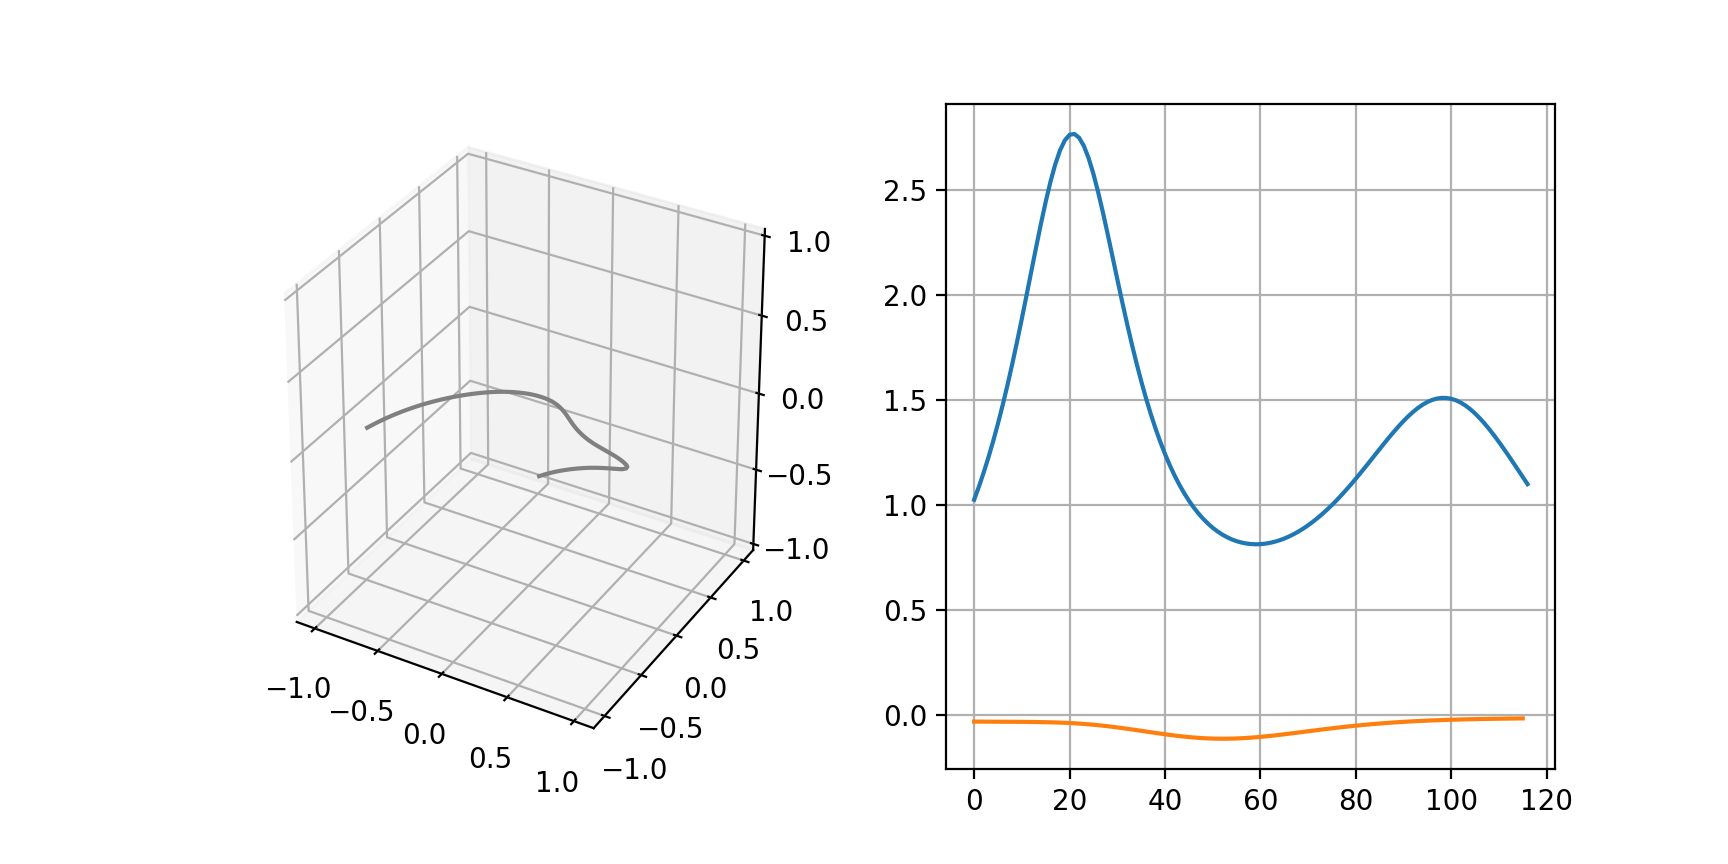

In [75]:
# Plot Curvature curve
index=21
Pts=cplr[index]
#Pts=ArcCplr[index]
Kurv=K[index]
Tor=T[index]
plotFrenetDesc(Pts,Kurv,Tor)

<IPython.core.display.Javascript object>


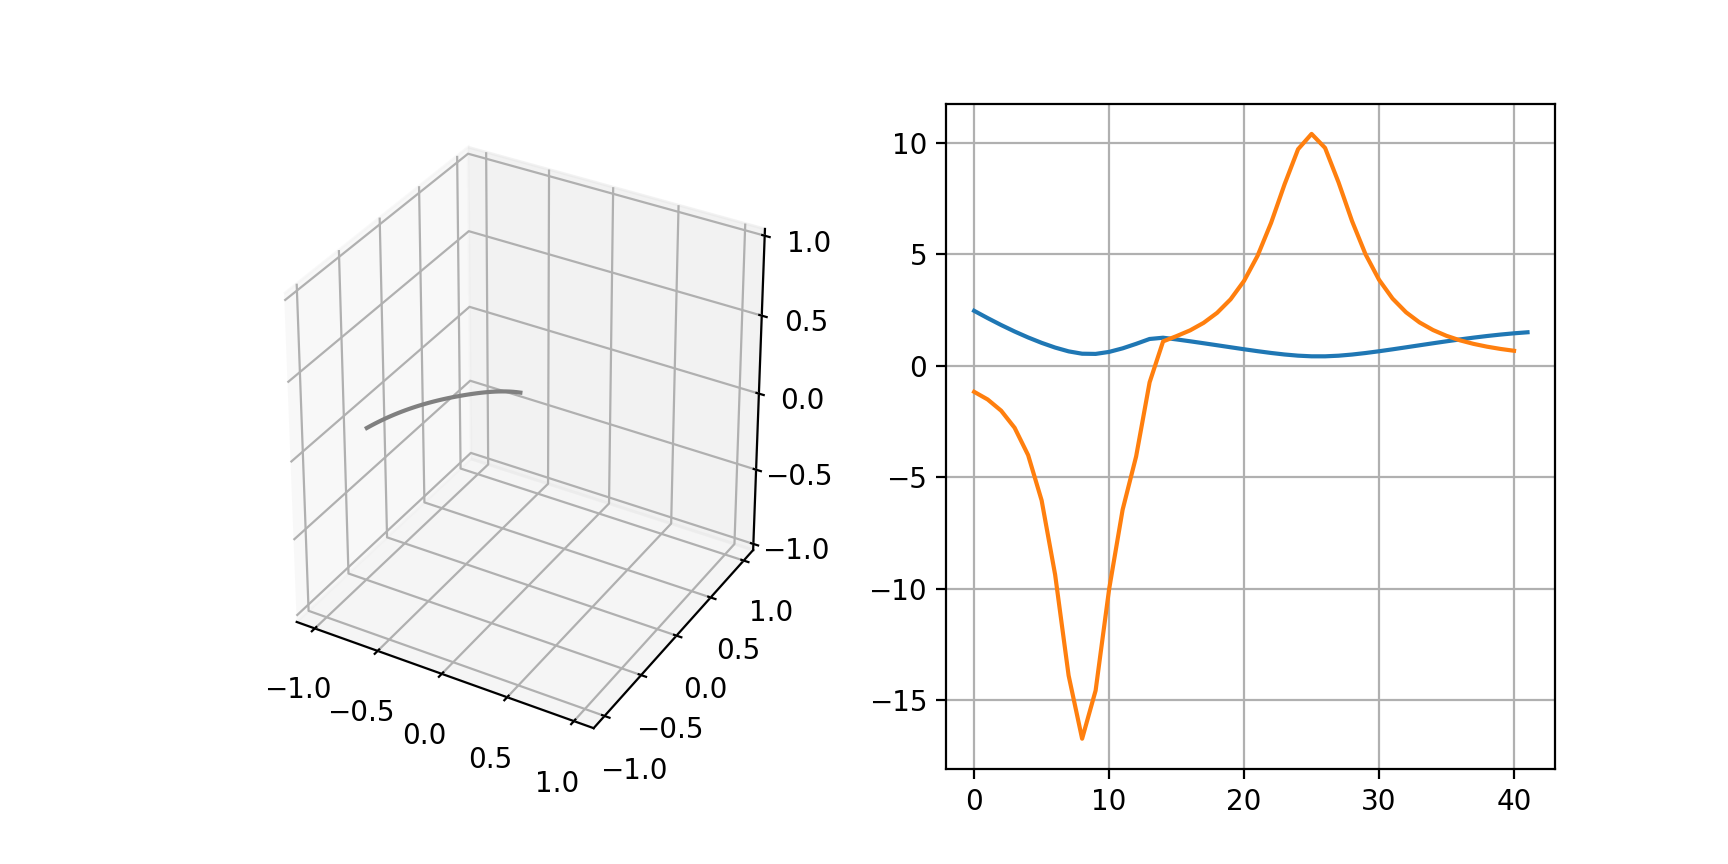

<IPython.core.display.Javascript object>


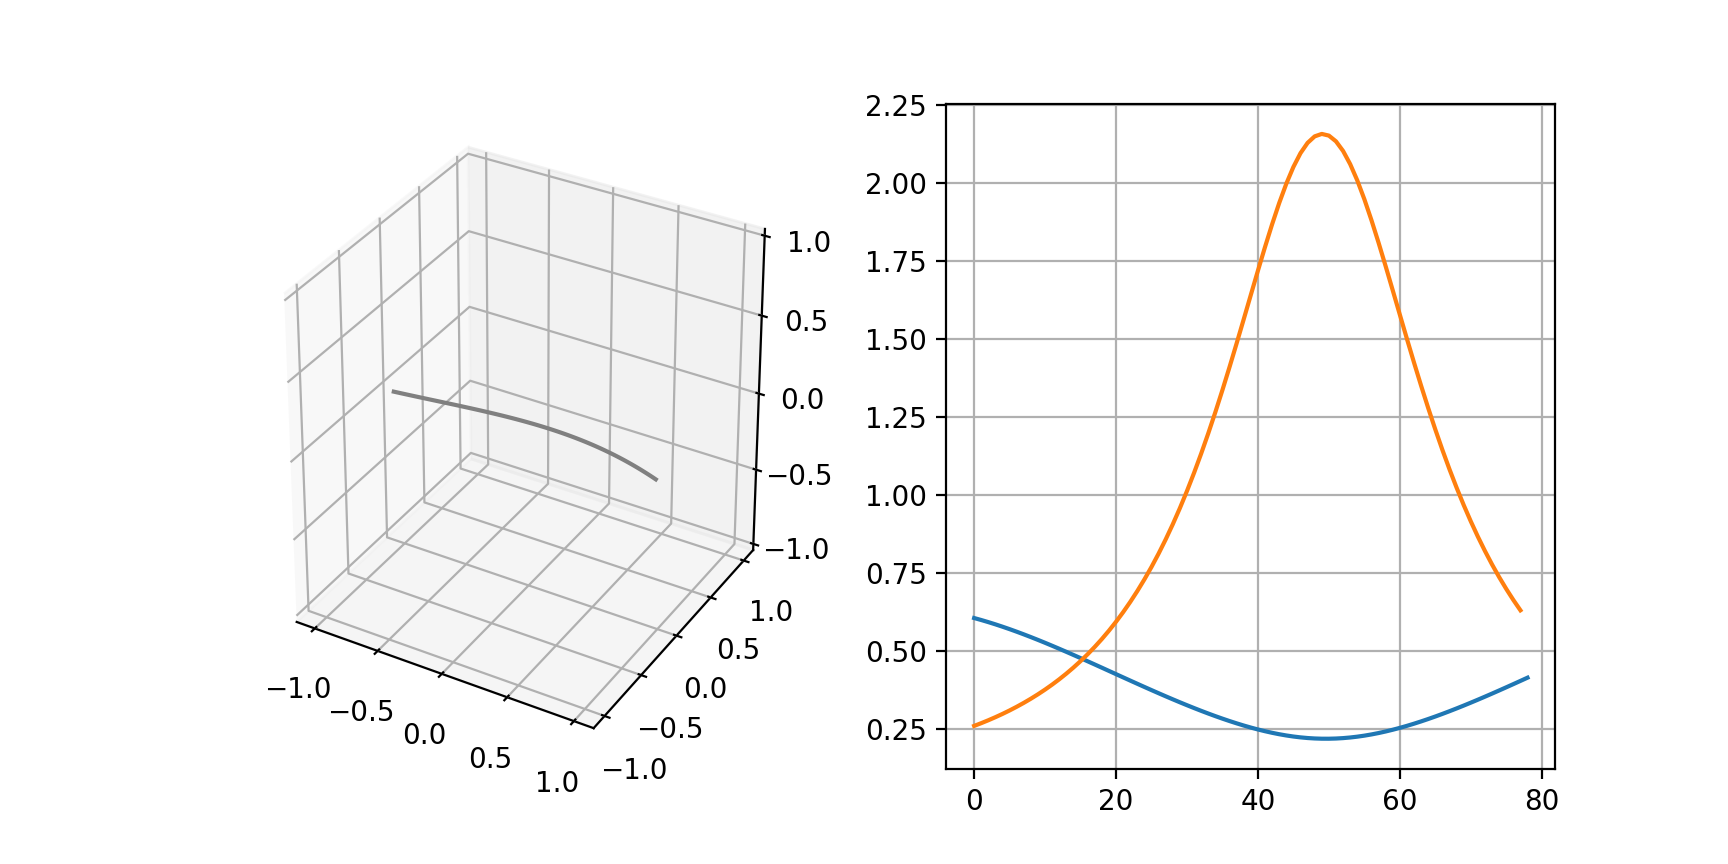

<IPython.core.display.Javascript object>


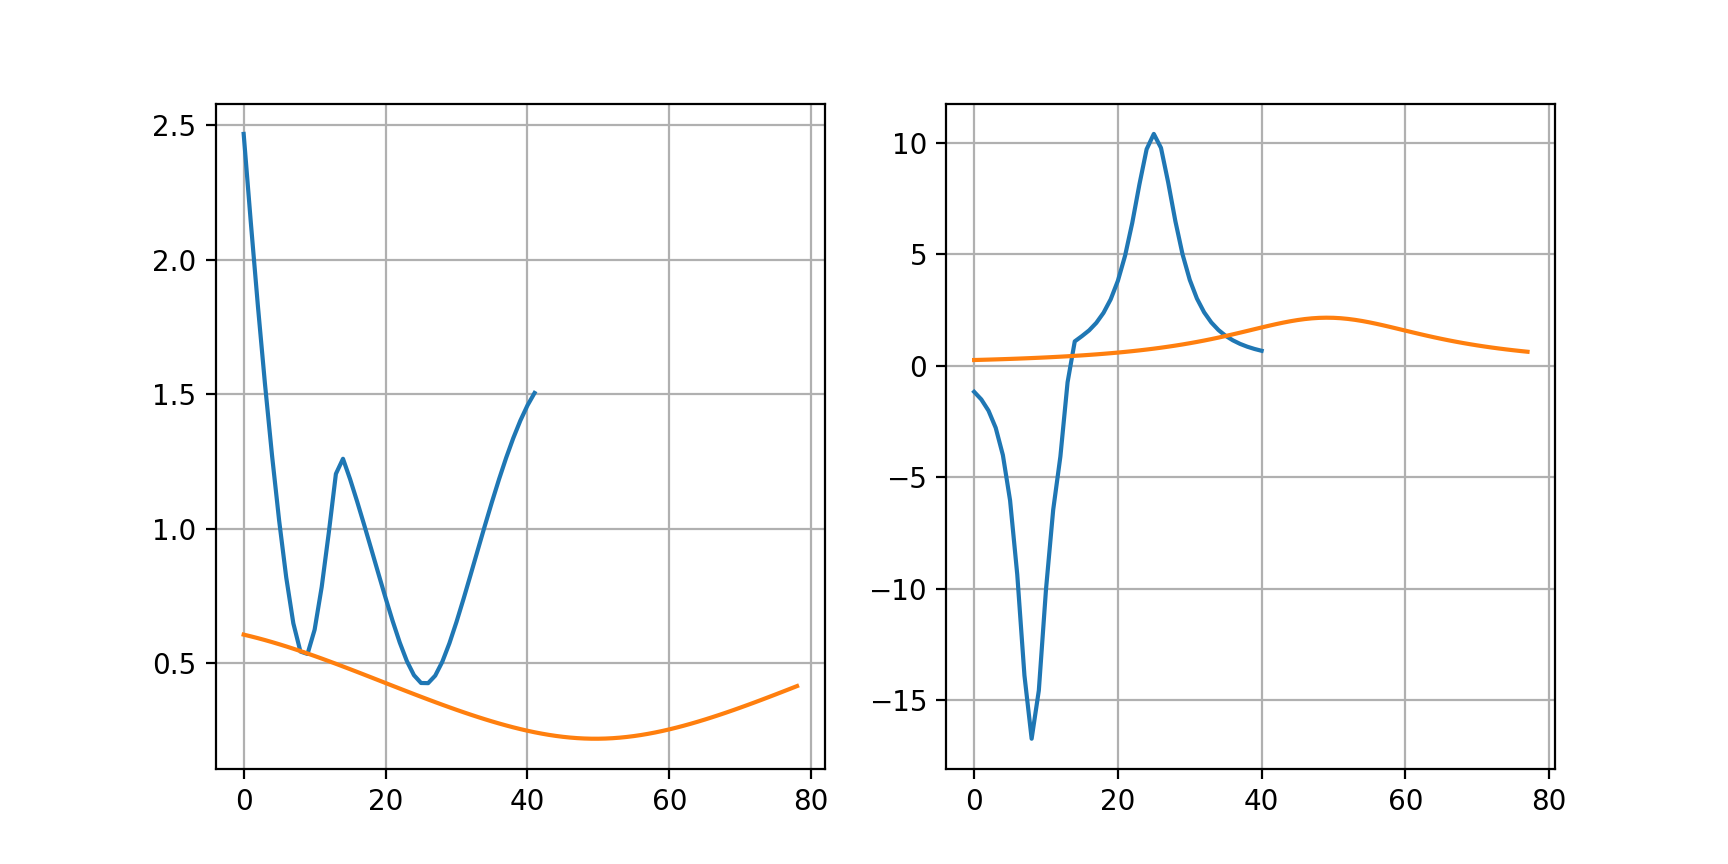

In [70]:
# Compare descriptors of a partial curve on Scaling
# Proves that if the parametrization is arc length based, the descriptors of scaled curve can change

def normalizePath(Path):
    #TRANSLATION
    T=np.mean(Path,axis=0)
    Trans_Path=Path-T

    #ROTATION
    Covariance_Mat=np.cov(Trans_Path,rowvar=0)
    sing_vec=LA.svd(Covariance_Mat)[0]
    R=sing_vec.T
    Rot_Path=np.matmul(R,Trans_Path.T).T
    
    #SCALING
    #S=np.max(np.std(Rot_Path,axis=0)) # Scale according to max st dev
    S=np.max(np.abs(Rot_Path)) # Scale largest dim to 1/-1 bound
    Scale_Path=Rot_Path/S

    return Scale_Path, T, R, S


partialPath1=Pts[75:150]
Ki1=Kurv[75:150]
Ti1=Tor[75:150]
plotFrenetDesc(partialPath1,Ki1,Ti1)

partialPath2,_,_,_=normalizePath(partialPath1)
partialPath2,param=arcLenParam(partialPath2)
_,_,_,Ki2,Ti2=calcFrenetDesc(partialPath2, param)
plotFrenetDesc(partialPath2,Ki2,Ti2)


fig = plt.figure(figsize=.9*plt.figaspect(1/2))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(len(Ki1)), Ki1);
ax.plot(range(len(Ki2)), Ki2);
plt.grid(True)
ax = fig.add_subplot(1, 2, 2)
ax.plot(range(len(Ti1)), Ti1);
ax.plot(range(len(Ti2)), Ti2);
plt.grid(True)
#plt.ylim(0, 1);
plt.show()

# Visualization of Diverse Data

# Add Mirrored mechanisms

In [ ]:
def mirror(Path,Mech,Plane):
    if Plane=='xy':
        index=2
    elif Plane=='yz':
        index=1
    elif Plane=='xz':
        index=0
    
    for i in range(len(Path)):
        Path[i][:,index]=-1*Path[i][:,index]
        Mech[i][:,index]=-1*Mech[i][:,index]
    
    return Path, Mech

cplr_x,mech_x=mirror(cplr.copy(),mech.copy(),'yz')
cplr_y,mech_y=mirror(cplr.copy(),mech.copy(),'xz')
cplr_z,mech_z=mirror(cplr.copy(),mech.copy(),'xy')

In [ ]:
Pts1=cplr_x[21]
Pts2=cplr_y[21]
Pts3=cplr_z[21]
fig = plt.figure(figsize=1*plt.figaspect(3/1))
ax = fig.add_subplot(3, 1, 1, projection='3d')
plotPath(Pts1, ax, 1)
ax = fig.add_subplot(3, 1, 2, projection='3d')
plotPath(Pts2, ax, 1)
ax = fig.add_subplot(3, 1, 3, projection='3d')
plotPath(Pts3, ax, 1)
plt.tight_layout(pad=0)

# Add Partial paths from complete paths

# Add Noise for robust feature extraction

# Store the Diverse Database

In [ ]:
np.savez('db_5SS_s1902_div', cplrData=DiverseCplrPathList, mechData=DiverseMechList) 

In [ ]:
db = np.load('db_5SS_s1902_div.npz')

In [ ]:
db.files

In [ ]:
print(db['cplrData'].shape)
print(db['mechData'].shape)